----------------------
Computer Science 5014 - Natural Language Processing
Student Full Name: Devansh Sundeep Mody
Student ID: 1130532
Student email: dmody@lakeheadu.ca
----------------------

# CS5014 Assignment 1: Exploring Word Vectors (100 Points)
### <font color='blue'> Due 11:59pm, Thursday 28 Jan. 2021 </font>

Welcome to CS5014! 

Before you start, make sure you read the README.txt in the same directory as this notebook. You will find many provided codes in the notebook. We highly encourage you to read and understand the provided codes as part of the learning :-)

In [27]:
# All Import Statements Defined Here
# Note: Do not add to this list.
# ----------------

import sys
assert sys.version_info[0]==3
assert sys.version_info[1] >= 5

from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
import nltk
nltk.download('reuters')
from nltk.corpus import reuters
import numpy as np
import random
import scipy as sp
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

START_TOKEN = '<START>'
END_TOKEN = '<END>'

np.random.seed(0)
random.seed(0)
# ----------------

[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data]   Package reuters is already up-to-date!


## Word Vectors

Word Vectors are often used as a fundamental component for downstream NLP tasks, e.g. question answering, text generation, translation, etc., so it is important to build some intuitions as to their strengths and weaknesses. Here, you will explore two types of word vectors: those derived from *co-occurrence matrices*, and those derived via *GloVe*. 

**Assignment Notes:** Please make sure to save the notebook as you go along. Submission Instructions are located at the bottom of the notebook.

**Note on Terminology:** The terms "word vectors" and "word embeddings" are often used interchangeably. The term "embedding" refers to the fact that we are encoding aspects of a word's meaning in a lower dimensional space. As [Wikipedia](https://en.wikipedia.org/wiki/Word_embedding) states, "*conceptually it involves a mathematical embedding from a space with one dimension per word to a continuous vector space with a much lower dimension*".

## Part 1: Count-Based Word Vectors (40 points)

Most word vector models start from the following idea:

*You shall know a word by the company it keeps ([Firth, J. R. 1957:11](https://en.wikipedia.org/wiki/John_Rupert_Firth))*

Many word vector implementations are driven by the idea that similar words, i.e., (near) synonyms, will be used in similar contexts. As a result, similar words will often be spoken or written along with a shared subset of words, i.e., contexts. By examining these contexts, we can try to develop embeddings for our words. With this intuition in mind, many "old school" approaches to constructing word vectors relied on word counts. Here we elaborate upon one of those strategies, *co-occurrence matrices* (for more information, see [here](http://web.stanford.edu/class/cs124/lec/vectorsemantics.video.pdf) or [here](https://medium.com/data-science-group-iitr/word-embedding-2d05d270b285)).

### Co-Occurrence

A co-occurrence matrix counts how often things co-occur in some environment. Given some word $w_i$ occurring in the document, we consider the *context window* surrounding $w_i$. Supposing our fixed window size is $n$, then this is the $n$ preceding and $n$ subsequent words in that document, i.e. words $w_{i-n} \dots w_{i-1}$ and $w_{i+1} \dots w_{i+n}$. We build a *co-occurrence matrix* $M$, which is a symmetric word-by-word matrix in which $M_{ij}$ is the number of times $w_j$ appears inside $w_i$'s window among all documents.

**Example: Co-Occurrence with Fixed Window of n=1**:

Document 1: "all that glitters is not gold"

Document 2: "all is well that ends well"


|     *    | `<START>` | all | that | glitters | is   | not  | gold  | well | ends | `<END>` |
|----------|-------|-----|------|----------|------|------|-------|------|------|-----|
| `<START>`    | 0     | 2   | 0    | 0        | 0    | 0    | 0     | 0    | 0    | 0   |
| all      | 2     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 0    | 0   |
| that     | 0     | 1   | 0    | 1        | 0    | 0    | 0     | 1    | 1    | 0   |
| glitters | 0     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 0    | 0   |
| is       | 0     | 1   | 0    | 1        | 0    | 1    | 0     | 1    | 0    | 0   |
| not      | 0     | 0   | 0    | 0        | 1    | 0    | 1     | 0    | 0    | 0   |
| gold     | 0     | 0   | 0    | 0        | 0    | 1    | 0     | 0    | 0    | 1   |
| well     | 0     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 1    | 1   |
| ends     | 0     | 0   | 1    | 0        | 0    | 0    | 0     | 1    | 0    | 0   |
| `<END>`      | 0     | 0   | 0    | 0        | 0    | 0    | 1     | 1    | 0    | 0   |

**Note:** In NLP, we often add `<START>` and `<END>` tokens to represent the beginning and end of sentences, paragraphs or documents. In thise case we imagine `<START>` and `<END>` tokens encapsulating each document, e.g., "`<START>` All that glitters is not gold `<END>`", and include these tokens in our co-occurrence counts.

The rows (or columns) of this matrix provide one type of word vectors (those based on word-word co-occurrence), but the vectors will be large in general (linear in the number of distinct words in a corpus). Thus, our next step is to run *dimensionality reduction*. In particular, we will run *SVD (Singular Value Decomposition)*, which is a kind of generalized *PCA (Principal Components Analysis)* to select the top $k$ principal components. Here's a visualization of dimensionality reduction with SVD. In this picture our co-occurrence matrix is $A$ with $n$ rows corresponding to $n$ words. We obtain a full matrix decomposition, with the singular values ordered in the diagonal $S$ matrix, and our new, shorter length-$k$ word vectors in $U_k$.
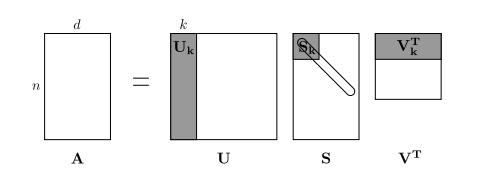
This reduced-dimensionality co-occurrence representation preserves semantic relationships between words, e.g. *doctor* and *hospital* will be closer than *doctor* and *dog*. 

**Notes:** If you can barely remember what an eigenvalue is, here's [a slow, friendly introduction to SVD](https://davetang.org/file/Singular_Value_Decomposition_Tutorial.pdf). If you want to learn more thoroughly about PCA or SVD, feel free to check out lectures [7](https://web.stanford.edu/class/cs168/l/l7.pdf), [8](http://theory.stanford.edu/~tim/s15/l/l8.pdf), and [9](https://web.stanford.edu/class/cs168/l/l9.pdf) of [the Modern Algorithmic Toolbox Course](https://web.stanford.edu/class/cs168/) at Stanford. These course notes provide a great high-level treatment of these general purpose algorithms. Though, for the purpose of this class, you only need to know how to extract the k-dimensional embeddings by utilizing pre-programmed implementations of these algorithms from the numpy, scipy, or sklearn python packages. In practice, it is challenging to apply full SVD to large corpora because of the memory needed to perform PCA or SVD. However, if you only want the top $k$ vector components for relatively small $k$ — known as [Truncated SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition#Truncated_SVD) — then there are reasonably scalable techniques to compute those iteratively.

### Plotting Co-Occurrence Word Embeddings

Here, we will be using the Reuters (business and financial news) corpus. If you haven't run the import cell at the top of this page, please run it now (click it and press SHIFT-RETURN). The corpus consists of 10,788 news documents totaling 1.3 million words. These documents span 90 categories and are split into train and test. For more details, please see https://www.nltk.org/book/ch02.html. We provide a `read_corpus` function below that pulls out only articles from the "crude" (i.e. news articles about oil, gas, etc.) category. The function also adds `<START>` and `<END>` tokens to each of the documents, and lowercases words. You do **not** have to perform any other kind of pre-processing.

In [28]:
def read_corpus(category="crude"):
    """ Read files from the specified Reuter's category.
        Params:
            category (string): category name
        Return:
            list of lists, with words from each of the processed files
    """
    files = reuters.fileids(category)
    return [[START_TOKEN] + [w.lower() for w in list(reuters.words(f))] + [END_TOKEN] for f in files]


In [29]:
reuters_corpus = read_corpus()

Let's have a look what these documents are like….

In [30]:
reuters_corpus = read_corpus()
pprint.pprint(reuters_corpus[:3], compact=True, width=100)

[['<START>', 'japan', 'to', 'revise', 'long', '-', 'term', 'energy', 'demand', 'downwards', 'the',
  'ministry', 'of', 'international', 'trade', 'and', 'industry', '(', 'miti', ')', 'will', 'revise',
  'its', 'long', '-', 'term', 'energy', 'supply', '/', 'demand', 'outlook', 'by', 'august', 'to',
  'meet', 'a', 'forecast', 'downtrend', 'in', 'japanese', 'energy', 'demand', ',', 'ministry',
  'officials', 'said', '.', 'miti', 'is', 'expected', 'to', 'lower', 'the', 'projection', 'for',
  'primary', 'energy', 'supplies', 'in', 'the', 'year', '2000', 'to', '550', 'mln', 'kilolitres',
  '(', 'kl', ')', 'from', '600', 'mln', ',', 'they', 'said', '.', 'the', 'decision', 'follows',
  'the', 'emergence', 'of', 'structural', 'changes', 'in', 'japanese', 'industry', 'following',
  'the', 'rise', 'in', 'the', 'value', 'of', 'the', 'yen', 'and', 'a', 'decline', 'in', 'domestic',
  'electric', 'power', 'demand', '.', 'miti', 'is', 'planning', 'to', 'work', 'out', 'a', 'revised',
  'energy', 'supply

### Question 1.1: Implement `distinct_words` [code] (8 points)

Write a method to work out the distinct words (word types) that occur in the corpus. You can do this with `for` loops, but it's more efficient to do it with Python list comprehensions. In particular, [this](https://coderwall.com/p/rcmaea/flatten-a-list-of-lists-in-one-line-in-python) may be useful to flatten a list of lists. If you're not familiar with Python list comprehensions in general, here's [more information](https://python-3-patterns-idioms-test.readthedocs.io/en/latest/Comprehensions.html).

You may find it useful to use [Python sets](https://www.w3schools.com/python/python_sets.asp) to remove duplicate words.

In [31]:
def distinct_words(corpus):
    """ Determine a list of distinct words for the corpus.
        Params:
            corpus (list of list of strings): corpus of documents
        Return:
            corpus_words (list of strings): list of distinct words across the corpus, sorted (using python 'sorted' function)
            num_corpus_words (integer): number of distinct words across the corpus
    """    
    # ------------------
    # Write your implementation here.
    #append word into the corpus_words list which is a list of distinct words
    corpus_words=[]
    num_corpus_words = -1
    for word in corpus:
          [corpus_words.append(x) for x in word if x not in corpus_words] 
 
    # sort the list
    corpus_words.sort()

    #total number of words in list
    num_corpus_words = len(corpus_words)
    # ------------------

    return corpus_words, num_corpus_words

In [32]:
# ---------------------
# Run this sanity check
# Note that this not an exhaustive check for correctness.
# ---------------------

# Define toy corpus
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
test_corpus_words, num_corpus_words = distinct_words(test_corpus)

# Correct answers
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
ans_num_corpus_words = len(ans_test_corpus_words)

# Test correct number of words
assert(num_corpus_words == ans_num_corpus_words), "Incorrect number of distinct words. Correct: {}. Yours: {}".format(ans_num_corpus_words, num_corpus_words)

# Test correct words
assert (test_corpus_words == ans_test_corpus_words), "Incorrect corpus_words.\nCorrect: {}\nYours:   {}".format(str(ans_test_corpus_words), str(test_corpus_words))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Question 1.2: Implement `compute_co_occurrence_matrix` [code] (12 points)

Write a method that constructs a co-occurrence matrix for a certain window-size $n$ (with a default of 4), considering words $n$ before and $n$ after the word in the center of the window. Here, we start to use `numpy (np)` to represent vectors, matrices, and tensors. If you're not familiar with NumPy, there's a NumPy tutorial in the second half of this [Python NumPy tutorial](http://cs231n.github.io/python-numpy-tutorial/) at [the Convolutional Neural Networks for Visual Recognition Course](https://cs231n.github.io/) at Stanford.


In [33]:
def compute_co_occurrence_matrix(corpus, window_size=4):
    """ Compute co-occurrence matrix for the given corpus and window_size (default of 4).
    
        Note: Each word in a document should be at the center of a window. Words near edges will have a smaller
              number of co-occurring words.
              
              For example, if we take the document "<START> All that glitters is not gold <END>" with window size of 4,
              "All" will co-occur with "<START>", "that", "glitters", "is", and "not".
    
        Params:
            corpus (list of list of strings): corpus of documents
            window_size (int): size of context window
        Return:
            M (a symmetric numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): 
                Co-occurence matrix of word counts. 
                The ordering of the words in the rows/columns should be the same as the ordering of the words given by the distinct_words function.
            word2Ind (dict): dictionary that maps word to index (i.e. row/column number) for matrix M.
    """
    # ------------------
    # Write your implementation here.
    words, num_words = distinct_words(corpus)
    #words contain distinct words and num_words contain number of such distinct words
    #M is the matrix and its size num_words by num_words i.e. M[num_words][num_words]
    M = np.zeros((num_words,num_words))
    word2Ind = {}
    #below part generates the co-occurence matrix for differnet words in sentence
    for i in range(num_words):
      word2Ind[words[i]] = i
    for sentence in corpus:
      for i in range(len(sentence)):
        target = sentence[i]
        target_index = word2Ind[target]
        left = max(i - window_size, 0)
        right = min(i + window_size, len(sentence) - 1)
        for j in range(left, i):
          window_word = sentence[j]
          M[target_index][word2Ind[window_word]] += 1
          M[word2Ind[window_word]][target_index] += 1

    return M, word2Ind
    # ------------------

In [34]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness.
# ---------------------

# Define toy corpus and get student's co-occurrence matrix
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2Ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)

# Correct M and word2Ind
M_test_ans = np.array( 
    [[0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,],
     [0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,],
     [1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,],
     [0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,],
     [0., 0., 1., 0., 1., 1., 0., 0., 0., 1.,],
     [1., 0., 0., 1., 1., 0., 0., 0., 1., 0.,]]
)
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
word2Ind_ans = dict(zip(ans_test_corpus_words, range(len(ans_test_corpus_words))))

# Test correct word2Ind
assert (word2Ind_ans == word2Ind_test), "Your word2Ind is incorrect:\nCorrect: {}\nYours: {}".format(word2Ind_ans, word2Ind_test)

# Test correct M shape
assert (M_test.shape == M_test_ans.shape), "M matrix has incorrect shape.\nCorrect: {}\nYours: {}".format(M_test.shape, M_test_ans.shape)

# Test correct M values
for w1 in word2Ind_ans.keys():
    idx1 = word2Ind_ans[w1]
    for w2 in word2Ind_ans.keys():
        idx2 = word2Ind_ans[w2]
        student = M_test[idx1, idx2]
        correct = M_test_ans[idx1, idx2]
        if student != correct:
            print("Correct M:")
            print(M_test_ans)
            print("Your M: ")
            print(M_test)
            raise AssertionError("Incorrect count at index ({}, {})=({}, {}) in matrix M. Yours has {} but should have {}.".format(idx1, idx2, w1, w2, student, correct))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Question 1.3: Implement `reduce_to_k_dim` [code] (4 point)

Construct a method that performs dimensionality reduction on the matrix to produce k-dimensional embeddings. Use SVD to take the top k components and produce a new matrix of k-dimensional embeddings. 

**Note:** All of numpy, scipy, and scikit-learn (`sklearn`) provide *some* implementation of SVD, but only scipy and sklearn provide an implementation of Truncated SVD, and only sklearn provides an efficient randomized algorithm for calculating large-scale Truncated SVD. So please use [sklearn.decomposition.TruncatedSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).

In [35]:
def reduce_to_k_dim(M, k=2):
    """ Reduce a co-occurence count matrix of dimensionality (num_corpus_words, num_corpus_words)
        to a matrix of dimensionality (num_corpus_words, k) using the following SVD function from Scikit-Learn:
            - http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
    
        Params:
            M (numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): co-occurence matrix of word counts
            k (int): embedding size of each word after dimension reduction
        Return:
            M_reduced (numpy matrix of shape (number of corpus words, k)): matrix of k-dimensioal word embeddings.
                    In terms of the SVD from math class, this actually returns U * S
    """    
    # ------------------
    # Write your implementation here.
    n_iters = 10     # Use this parameter in your call to `TruncatedSVD`
    M_reduced = None
    print("Running Truncated SVD over %i words..." % (M.shape[0]))
    svd = TruncatedSVD(n_components=k, n_iter=n_iters, random_state=42)
    M_reduced=svd.fit_transform(M)
    
    # ------------------

    print("Done.")
    return M_reduced

In [36]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness 
# In fact we only check that your M_reduced has the right dimensions.
# ---------------------

# Define toy corpus and run student code
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2Ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)
M_test_reduced = reduce_to_k_dim(M_test, k=2)

# Test proper dimensions
assert (M_test_reduced.shape[0] == 10), "M_reduced has {} rows; should have {}".format(M_test_reduced.shape[0], 10)
assert (M_test_reduced.shape[1] == 2), "M_reduced has {} columns; should have {}".format(M_test_reduced.shape[1], 2)

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

Running Truncated SVD over 10 words...
Done.
--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Question 1.4: Implement `plot_embeddings` [code] (4 point)

Here you will write a function to plot a set of 2D vectors in 2D space. For graphs, we will use Matplotlib (`plt`).

For this example, you may find it useful to adapt [this code](https://www.pythonmembers.club/2018/05/08/matplotlib-scatter-plot-annotate-set-text-at-label-each-point/). In the future, a good way to make a plot is to look at [the Matplotlib gallery](https://matplotlib.org/gallery/index.html), find a plot that looks somewhat like what you want, and adapt the code they give.

In [37]:
def plot_embeddings(M_reduced, word2Ind, words):
    """ Plot in a scatterplot the embeddings of the words specified in the list "words".
        NOTE: do not plot all the words listed in M_reduced / word2Ind.
        Include a label next to each point.
        
        Params:
            M_reduced (numpy matrix of shape (number of unique words in the corpus , 2)): matrix of 2-dimensioal word embeddings
            word2Ind (dict): dictionary that maps word to indices for matrix M
            words (list of strings): words whose embeddings we want to visualize
    """
    # ------------------
    # Write your implementation here.
    words_index = [word2Ind[word] for word in words]
    print(words_index)
    x = [M_reduced[word_index][0] for word_index in words_index]
    y = [M_reduced[word_index][1] for word_index in words_index]
    
    #plt.figure(figsize=(10,10))
    for i in range(0,len(words)):
        plt.scatter(x[i],y[i],marker='x',color = 'red')
        plt.text(x[i]+0.0005,y[i]+0.0005,words[i],fontsize=10)
    plt.show()
    

    # ------------------

--------------------------------------------------------------------------------
Outputted Plot:
[0, 1, 2, 3, 4]


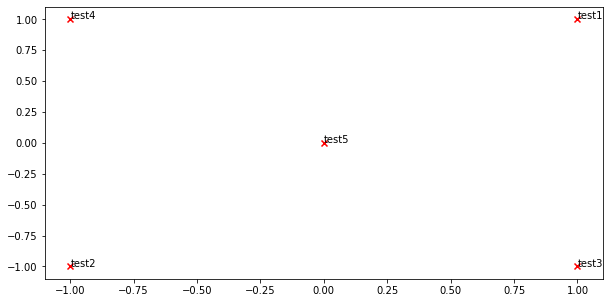

--------------------------------------------------------------------------------


In [38]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness.
# The plot produced should look like the "test solution plot" depicted below. 
# ---------------------

print ("-" * 80)
print ("Outputted Plot:")

M_reduced_plot_test = np.array([[1, 1], [-1, -1], [1, -1], [-1, 1], [0, 0]])
word2Ind_plot_test = {'test1': 0, 'test2': 1, 'test3': 2, 'test4': 3, 'test5': 4}
words = ['test1', 'test2', 'test3', 'test4', 'test5']
plot_embeddings(M_reduced_plot_test, word2Ind_plot_test, words)

print ("-" * 80)

# <font color=red>**Test Plot Solution**</font>
<br>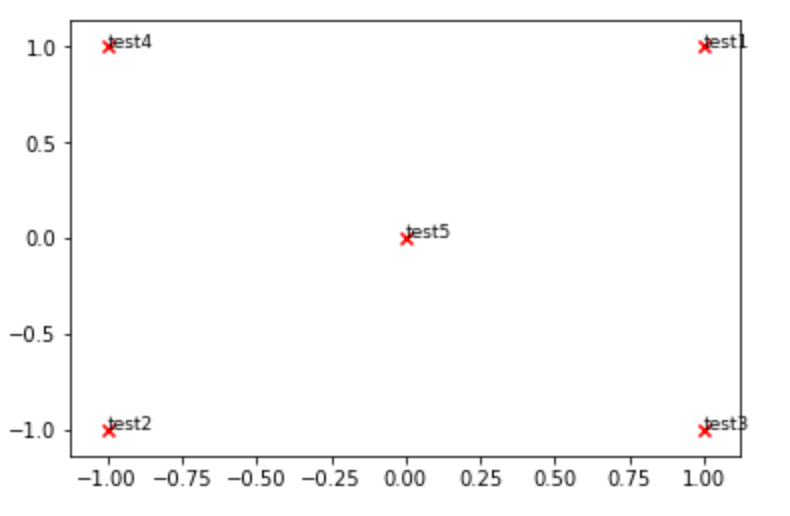

### Question 1.5: Co-Occurrence Plot Analysis [written] (12 points)

Now we will put together all the parts you have written! We will compute the co-occurrence matrix with fixed window of 4 (the default window size), over the Reuters "crude" (oil) corpus. Then we will use TruncatedSVD to compute 2-dimensional embeddings of each word. TruncatedSVD returns U\*S, so we need to normalize the returned vectors, so that all the vectors will appear around the unit circle (therefore closeness is directional closeness). **Note**: The line of code below that does the normalizing uses the NumPy concept of *broadcasting*. If you don't know about broadcasting, check out
[Computation on Arrays: Broadcasting by Jake VanderPlas](https://jakevdp.github.io/PythonDataScienceHandbook/02.05-computation-on-arrays-broadcasting.html).

Run the below cell to produce the plot. It'll probably take a few seconds to run. What clusters together in 2-dimensional embedding space? What doesn't cluster together that you might think should have?  **Note:** "bpd" stands for "barrels per day" and is a commonly used abbreviation in crude oil topic articles.

Running Truncated SVD over 8185 words...
Done.
[1252, 1454, 2729, 2840, 3961, 4285, 5165, 5298, 5517, 7862]


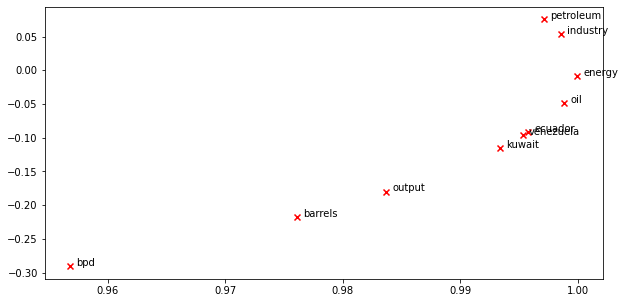

In [39]:
# -----------------------------
# Run This Cell to Produce Your Plot
# ------------------------------
reuters_corpus = read_corpus()
M_co_occurrence, word2Ind_co_occurrence = compute_co_occurrence_matrix(reuters_corpus)
M_reduced_co_occurrence = reduce_to_k_dim(M_co_occurrence, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced_co_occurrence, axis=1)
M_normalized = M_reduced_co_occurrence / M_lengths[:, np.newaxis] # broadcasting

words = ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela']

plot_embeddings(M_normalized, word2Ind_co_occurrence, words)

#### <font color="red">Write your answer here.</font>
reuters corpus for category crude is read,then we compute the cooccurence matrix,then reduce the dimensions of the matrix,then it's normalized and the embeddings are plotted for the words given in words list:
Following is my obseravaion for the embeddings plotted:
* Q1) What clusters together in 2-dimensional embedding space?
* answer for Q1 in points:-
* Ecuador and Venezuela are clubbed together as the two are countries in South America
* Also kuwait is bit close to Ecuador and Venezula
Also these three nations are major crude oil
producing nations in the wrold so they are
part of the same cluster and appear closer in the ouput when compared with others.
* petroleum and industry are clustered as they appear to close enough also becuase whenever the word petroleum is pronounced the next word that comes is often industry that is most of the time its  pronounced as pteroleum industry in news or articles, so petroleum and industry appear together.
* oil and energy are clustered together, oil is always seen as source of energy.by products of oil are used to power various systems like cars, powerplants etc.
* Q2)What doesn't cluster together that you might think should have?
* answer for Q2 in points:
* oil and petroleum are both liquid fuels and should be clustered together but appear far apart
* similarly bpd(barrels per day), output and barrels should be clustered together but appear far apart.


## Part 2: Prediction-Based Word Vectors (60 points)

As discussed in class, more recently prediction-based word vectors have demonstrated better performance, such as word2vec and GloVe (which also utilizes the benefit of counts). Here, we shall explore the embeddings produced by GloVe. Please revisit the class notes and lecture slides for more details on the word2vec and GloVe algorithms. If you're feeling adventurous, challenge yourself and try reading [GloVe's original paper](https://nlp.stanford.edu/pubs/glove.pdf).

Then run the following cells to load the GloVe vectors into memory. **Note**: If this is your first time to run these cells, i.e. download the embedding model, it will take about 15 minutes to run. If you've run these cells before, rerunning them will load the model without redownloading it, which will take about 1 to 2 minutes.

In [40]:
def load_embedding_model():
    """ Load GloVe Vectors
        Return:
            wv_from_bin: All 400000 embeddings, each lengh 200
    """
    import gensim.downloader as api
    wv_from_bin = api.load("glove-wiki-gigaword-200")
    print("Loaded vocab size %i" % len(wv_from_bin.vocab.keys()))
    return wv_from_bin

In [41]:
# -----------------------------------
# Run Cell to Load Word Vectors
# Note: This will take several minutes
# -----------------------------------
wv_from_bin = load_embedding_model()

Loaded vocab size 400000


In [42]:
wv_from_bin

#### Note: If you are receiving reset by peer error, rerun the cell to restart the download. 

### Reducing dimensionality of Word Embeddings
Let's directly compare the GloVe embeddings to those of the co-occurrence matrix. In order to avoid running out of memory, we will work with a sample of 10000 GloVe vectors instead.
Run the following cells to:

1. Put 10000 Glove vectors into a matrix M
2. Run reduce_to_k_dim (your Truncated SVD function) to reduce the vectors from 200-dimensional to 2-dimensional.

In [43]:
def get_matrix_of_vectors(wv_from_bin, required_words=['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela']):
    """ Put the GloVe vectors into a matrix M.
        Param:
            wv_from_bin: KeyedVectors object; the 400000 GloVe vectors loaded from file
        Return:
            M: numpy matrix shape (num words, 200) containing the vectors
            word2Ind: dictionary mapping each word to its row number in M
    """
    import random
    words = list(wv_from_bin.vocab.keys())
    print("Shuffling words ...")
    random.seed(224)
    random.shuffle(words)
    words = words[:10000]
    print("Putting %i words into word2Ind and matrix M..." % len(words))
    word2Ind = {}
    M = []
    curInd = 0
    for w in words:
        try:
            M.append(wv_from_bin.word_vec(w))
            word2Ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    for w in required_words:
        if w in words:
            continue
        try:
            M.append(wv_from_bin.word_vec(w))
            word2Ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    M = np.stack(M)
    print("Done.")
    return M, word2Ind

In [44]:
# -----------------------------------------------------------------
# Run Cell to Reduce 200-Dimensional Word Embeddings to k Dimensions
# Note: This should be quick to run
# -----------------------------------------------------------------
M, word2Ind = get_matrix_of_vectors(wv_from_bin)
M_reduced = reduce_to_k_dim(M, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced, axis=1)
M_reduced_normalized = M_reduced / M_lengths[:, np.newaxis] # broadcasting

Shuffling words ...
Putting 10000 words into word2Ind and matrix M...
Done.
Running Truncated SVD over 10010 words...
Done.


**Note: If you are receiving out of memory issues on your local machine, try closing other applications to free more memory on your device. You may want to try restarting your machine so that you can free up extra memory. Then immediately run the jupyter notebook and see if you can load the word vectors properly. If you still have problems with loading the embeddings onto your local machine after this, please follow the Piazza instructions, as how to run remotely on Stanford Farmshare machines.**

### Question 2.1: GloVe Plot Analysis [written] (16 points)

Run the cell below to plot the 2D GloVe embeddings for `['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela']`.

What clusters together in 2-dimensional embedding space? What doesn't cluster together that you might think should have? How is the plot different from the one generated earlier from the co-occurrence matrix? What is a possible reason for causing the difference?

[10000, 10001, 10002, 10003, 10004, 10005, 10006, 10007, 10008, 10009]


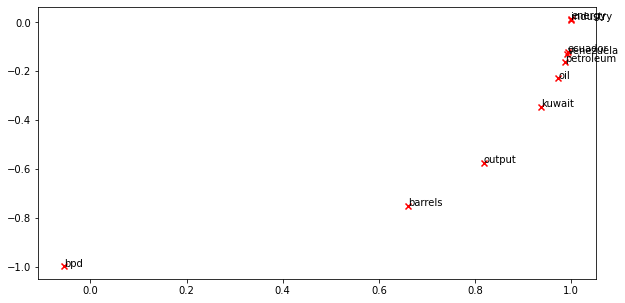

In [45]:
words = ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela']
plot_embeddings(M_reduced_normalized, word2Ind, words)


#### <font color="red">Write your answer here.</font>
1. What clusters together in 2-dimensional embedding space? 
answer:
* energy and industry cluster together 
* eucador and venezuela are clustered together south american states
* also this time petroleum and oil both are fuels and clustered together
* moreover ecudaor,venezuela,petroleum and oil appear to be close enough and are clustered together.
2. What doesn't cluster together that you might think should have? 
answer:
* bpd, output and barrels should have been clustered together 
* Also kuwait should be close enough to or clustered with eucador and venezuela but it appears to be far enough from them.
3. How is the plot different from the one generated earlier from the co-occurrence matrix?
answer:
* in the above plot petroleum and industry were close enough in one cluster ,whereas in this plot energy and industry are close enough in one cluster
* also in the first plot without glove the oil and peteroleum were far enough and with glove this problem is solved both oil and peteroleum are fuel and now the appear in one cluster and are close enough.
* kuwait was close enough to eucador and venezuela but in this with glove embeddings, kuwait is far away from both venezuela and eucador
4. What is a possible reason for causing the difference?
answer: 
* Glove as the name suggests is better for preserving the global contexts as it creates a global co-occurrence matrix by estimating the probability of a given word will co-occur with other words. 
* window based co-occurence matrix embeddings, these word2vec embeddings do not cluster together countries.
* In second plot glove embeddings have been used which is more efficient 
* Word2Vec does well in learnig words similarity from context words, so the words in cluster are close word(semantic and part of speech).
* Co-occurence does well in learning words similarity from context words even the words that are not close in part of speech.
* In general the Word2Vec plot have these words at much better separation than co-occurence matrix.



### Cosine Similarity
Now that we have word vectors, we need a way to quantify the similarity between individual words, according to these vectors. One such metric is cosine-similarity. We will be using this to find words that are "close" and "far" from one another.

We can think of n-dimensional vectors as points in n-dimensional space. If we take this perspective [L1](http://mathworld.wolfram.com/L1-Norm.html) and [L2](http://mathworld.wolfram.com/L2-Norm.html) Distances help quantify the amount of space "we must travel" to get between these two points. Another approach is to examine the angle between two vectors. From trigonometry we know that:

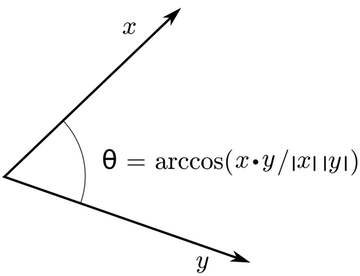

Instead of computing the actual angle, we can leave the similarity in terms of $similarity = cos(\Theta)$. Formally the [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity) $s$ between two vectors $p$ and $q$ is defined as:

$$s = \frac{p \cdot q}{||p|| ||q||}, \textrm{ where } s \in [-1, 1] $$ 

### Question 2.2: Words with Multiple Meanings (8 points) [code + written] 
Polysemes and homonyms are words that have more than one meaning (see this [wiki page](https://en.wikipedia.org/wiki/Polysemy) to learn more about the difference between polysemes and homonyms ). Find a word with at least 2 different meanings such that the top-10 most similar words (according to cosine similarity) contain related words from *both* meanings. For example, "leaves" has both "vanishes" and "stalks" in the top 10, and "scoop" has both "handed_waffle_cone" and "lowdown". You will probably need to try several polysemous or homonymic words before you find one. Please state the word you discover and the multiple meanings that occur in the top 10. Why do you think many of the polysemous or homonymic words you tried didn't work (i.e. the top-10 most similar words only contain **one** of the meanings of the words)?

**Note**: You should use the `wv_from_bin.most_similar(word)` function to get the top 10 similar words. This function ranks all other words in the vocabulary with respect to their cosine similarity to the given word. For further assistance please check the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.most_similar)__.

In [46]:
# ------------------
# Write your implementation here.
#polysemes words discovered and the multiple meanings that occur in the top 10
polysemy_word=["glare","writer","accept","lie","current","pine","count","fair","bank","head"]
for i in polysemy_word:
  print(("polysemy word:{}".format(i),wv_from_bin.most_similar([i])))
  print("------------------")

#homonyms words discovered and the multiple meanings that occur in the top 10
homonyms_word=["ate","mail","tail","bat","ball","sell","write","beat","boar","cent"]
for j in homonyms_word:
  print(("homonyms word:{}".format(j),wv_from_bin.most_similar([j])))
  print("------------------")
# ------------------

('polysemy word:glare', [('blinding', 0.603436291217804), ('spotlight', 0.556220293045044), ('shone', 0.5401158332824707), ('sunlight', 0.5361401438713074), ('klieg', 0.5355580449104309), ('flashes', 0.5144102573394775), ('shine', 0.5067466497421265), ('withering', 0.504528284072876), ('shines', 0.4924159348011017), ('lights', 0.4889742136001587)])
------------------
('polysemy word:writer', [('novelist', 0.7804421186447144), ('author', 0.7788338661193848), ('writers', 0.7721041440963745), ('journalist', 0.6974388360977173), ('editor', 0.6508176326751709), ('screenwriter', 0.6456747651100159), ('reporter', 0.6440116763114929), ('poet', 0.6359722018241882), ('contributed', 0.6224184036254883), ('playwright', 0.6220184564590454)])
------------------
('polysemy word:accept', [('accepted', 0.7917158007621765), ('agree', 0.7556045055389404), ('reject', 0.7472240924835205), ('refuse', 0.7235544919967651), ('willing', 0.721200168132782), ('accepting', 0.7130648493766785), ('refused', 0.702893

#### <font color="red">Write your answer here.</font>
*  Polysemy: Words that have multiple meanings that are related conceptually in some way. Polysemy may create lexical ambiguity and vagueness. A word is polysemous if it can be used to express different meanings. Some words, such as run or set have more than thirty different meanings.for example writer and author are polysemy words, also accept and agree means same things so like these words are pronounced differently but their meaning is same. many other similar words can be find in print output of the above code

*  homonyms: Words that are different in meaning but are pronounced the same (spelling is irrelevant). Two or more words are homonyms if they either sound the same (homophones), have the same spelling (homographs), or both, but do not have related meanings. for example tail and tale are pronounced same but their meaning is different tail means ends of something like "we have reached the tail of the road", "dog has a long tail" etc and tale means a story or narrative. similarly mail and male is pronounced same but has different meaning mail means to send letter to someone or email whereas male means human being so these are few examples of homonyms words. many other similar words can be find in print output of the above code

*   polysemy or homonyms words tried but didn't work: 
*   Polysemous words I tried which didn't work - 
1.  word current meaning recent and electricity but the model only showed the words which mean "recent" or unrelated words.
2.  word pine meaning a type of tree and hope, but the model only showed the words which mean "tree".
3.  word bank meaning a financial institution and river bank or reliable, but the model only showed words for "Financial Institution".
4.  word count meaning figuring out number of items or reliable or a noble, but the model only showed words for "figuring out the number of items".
5.  word fair meaning reasonable or just and white but the model only showed output for "reasonable".
6. word head means to lead some organization or body part but it displayed the head positions only. also lies had many uncorrelated words like sit,lay and other words that can be seen in print output.
 
* homonyms words I tried which didn't work - 
1.  word ate meaning to consume food but the model only showed the words which mean eating,cooking,hamburger which are not related.
2.  word tails meaning end,last,rear etc but the model only showed the uncorelatd words like fin,feathers,nose,legs.
3.  words like bat means an animal and ball means something which is circular but for both the words it showed the words related to sports like cricket and baseball. it showed words like batting, catch,pitch which are uncorrelated
4.  word boar its a wild animal so similar words like wild boar, hog,pig, swine its should be shown but it showed totally uncorrelated words like deer,and other words
5. word cent it should give ouput penny, currency, dollar etc but gives output of words like gallon, percent and few numbers which has no relation with the word

* The reason why word that i tried but didn't work is the data source, the corpus or data source is most important as word embeddings are learned from the corpus and it can be biased towards more common use cases than even distribution of different meanings the word may have.




### Question 2.3: Synonyms & Antonyms (8 points) [code + written] 

When considering Cosine Similarity, it's often more convenient to think of Cosine Distance, which is simply 1 - Cosine Similarity.

Find three words (w1,w2,w3) where w1 and w2 are synonyms and w1 and w3 are antonyms, but Cosine Distance(w1,w3) < Cosine Distance(w1,w2). For example, w1="happy" is closer to w3="sad" than to w2="cheerful". 

Once you have found your example, please give a possible explanation for why this counter-intuitive result may have happened.

You should use the the `wv_from_bin.distance(w1, w2)` function here in order to compute the cosine distance between two words. Please see the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.distance)__ for further assistance.

In [47]:
    # ------------------
    # Write your implementation here.
    w1="start"
    w2="begining"
    w3="end"
    print("Antonyms\t\t",wv_from_bin.distance(w1,w3))
    print("*************")
    print("Synonyms\t\t",wv_from_bin.distance(w1,w2))
    print("*************")
    # ------------------

Antonyms		 0.3150216341018677
*************
Synonyms		 0.9385420866310596
*************


#### <font color="red">Write your answer here.</font>
Explanation for why this counter-intuitive result may have happened:
1.  Word2vec does not capture similarity based on antonyms and synonyms. Word2vec would give a higher similarity if the two words have the similar context. For example "The race will ___from here onwards". The blank could be filled by both start and begining hence the similarity would be higher. This concept is called Paradigmatic relations.
2.  Even though the cosine distance between start and begining is more than the cosine distance between start and end,is counter intuititive. The reason this happens is because the start and end would be rated on similarly on several parameters/dimensions. Therefore, it makes sense that they would have lower cosine distance.
3. Synonyms are not typically used all together in the same sentence as much as antonyms. For our example - If the text corpus is coming from news articles. On news articles, It is very common to critically compare contrasting ideas using antonyms than using synonyms to describe the same ideas in a context, and as word2vec algorithm works by learning the corpus it ofen groups these words together based on their occurence and so the cosine distance between the words is less.



### Solving Analogies with Word Vectors
Word vectors have been shown to *sometimes* exhibit the ability to solve analogies. 

As an example, for the analogy "man : king :: woman : x" (read: man is to king as woman is to x), what is x?

In the cell below, we show you how to use word vectors to find x. The `most_similar` function finds words that are most similar to the words in the `positive` list and most dissimilar from the words in the `negative` list. The answer to the analogy will be the word ranked most similar (largest numerical value).

**Note:** Further Documentation on the `most_similar` function can be found within the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.most_similar)__.

In [48]:
# Run this cell to answer the analogy -- man : king :: woman : x
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'king'], negative=['man']))

[('queen', 0.6978678703308105),
 ('princess', 0.6081745028495789),
 ('monarch', 0.5889754891395569),
 ('throne', 0.5775108933448792),
 ('prince', 0.5750998854637146),
 ('elizabeth', 0.546359658241272),
 ('daughter', 0.5399125814437866),
 ('kingdom', 0.5318052768707275),
 ('mother', 0.5168544054031372),
 ('crown', 0.5164472460746765)]


### Question 2.4: Finding Analogies [code + written]  (8 Points)
Find an example of analogy that holds according to these vectors (i.e. the intended word is ranked top). In your solution please state the full analogy in the form x:y :: a:b. If you believe the analogy is complicated, explain why the analogy holds in one or two sentences.

**Note**: You may have to try many analogies to find one that works!

In [49]:
    # ------------------
    # Write your implementation here.
    # Run this cell to answer the analogy -- boy:handsome :: girl:?
    pprint.pprint(wv_from_bin.most_similar(positive=['girl','handsome'], negative=['boy']))

    # ------------------

[('charming', 0.6295403242111206),
 ('beautiful', 0.6100110411643982),
 ('gorgeous', 0.603277325630188),
 ('lovely', 0.599654495716095),
 ('blonde', 0.5770339965820312),
 ('elegant', 0.5692319869995117),
 ('attractive', 0.5644859671592712),
 ('blond', 0.5592210292816162),
 ('glamorous', 0.5540317296981812),
 ('ruggedly', 0.5484222173690796)]


#### <font color="red">Write your answer here.</font>
* this is the analogy boy:handsome :: girl:?
* the ouput we get is perfect that is the intended word charming rank at the top from the rest of the words in the above output.
* also it can be observed the words charming, beautiful,gorgeous,lovely,blonde,elegant are ranked much higer and these words are closely related to the girl and charming being ranked the highest amongst of all.
* In word embedding space, each word meaning are embeded as a point, and each directions also contain a specific meaning.





### Question 2.5: Incorrect Analogy [code + written] (4 point)
Find an example of analogy that does *not* hold according to these vectors. In your solution, state the intended analogy in the form x:y :: a:b, and state the (incorrect) value of b according to the word vectors.

In [50]:
    # ------------------
    # Write your implementation here.
    # lawyer: defendant :: teacher: student
    # strawbeery:red::orange:orange
    #pprint.pprint(wv_from_bin.most_similar(positive=['defendant', 'teacher'], negative=['lawyer']))
    pprint.pprint(wv_from_bin.most_similar(positive=['strawberry', 'orange'], negative=['red']))

    # ------------------

[('shortcake', 0.5532868504524231),
 ('citrus', 0.5475609302520752),
 ('peach', 0.5176042914390564),
 ('cranberry', 0.4920293092727661),
 ('pineapple', 0.4672635793685913),
 ('banana', 0.46659746766090393),
 ('blueberry', 0.46470314264297485),
 ('guava', 0.46126753091812134),
 ('mango', 0.45692020654678345),
 ('juice', 0.4547979235649109)]


#### <font color="red">Write your answer here.</font>

1. analogy is strawbeery:red::orange:orange
2. It can be seen that the expected result is the colour of the orange that is orange but it gives uncorrelated values
3. I expected strawberry-red+orange = orange , that is i expected orange as output.
4. However, the answer doesn't work perhaps because the two words are same.
5. The results I have got are shortcake,citrus,peach,cranberry,pineapple,banana,blueberry,guava,mango and juice.



### Question 2.6: Guided Analysis of Bias in Word Vectors [written] (4 point)

It's important to be cognizant of the biases (gender, race, sexual orientation etc.) implicit in our word embeddings. Bias can be dangerous because it can reinforce stereotypes through applications that employ these models.

Run the cell below, to examine (a) which terms are most similar to "woman" and "worker" and most dissimilar to "man", and (b) which terms are most similar to "man" and "worker" and most dissimilar to "woman". Point out the difference between the list of female-associated words and the list of male-associated words, and explain how it is reflecting gender bias.

In [51]:
# Run this cell
# Here `positive` indicates the list of words to be similar to and `negative` indicates the list of words to be
# most dissimilar from.
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'worker'], negative=['man']))
print("----------------")
pprint.pprint(wv_from_bin.most_similar(positive=['man', 'worker'], negative=['woman']))

[('employee', 0.6375863552093506),
 ('workers', 0.6068919897079468),
 ('nurse', 0.5837947726249695),
 ('pregnant', 0.5363885164260864),
 ('mother', 0.5321309566497803),
 ('employer', 0.5127025842666626),
 ('teacher', 0.5099576711654663),
 ('child', 0.5096741914749146),
 ('homemaker', 0.5019454956054688),
 ('nurses', 0.4970572590827942)]
----------------
[('workers', 0.6113258004188538),
 ('employee', 0.5983108282089233),
 ('working', 0.5615328550338745),
 ('laborer', 0.5442320108413696),
 ('unemployed', 0.5368517637252808),
 ('job', 0.5278826951980591),
 ('work', 0.5223963260650635),
 ('mechanic', 0.5088937282562256),
 ('worked', 0.505452036857605),
 ('factory', 0.4940453767776489)]


#### <font color="red">Write your answer here.</font>
* difference between male and female associated words:
  * list of male associated word dosen't contain words nurse,pregnant,mother,employer,teacher,child,homemaker and nurses
  * list of female associated word dosen't contain words working,laborer,unemployed,job,mechanic,worked and factory
* it can be seen that based on the words associated with male and female a common perception is made about their work,for example only females can be nurse and male cannot be nurse, also female can be housemaker whereas man cannot be, also man can be a factory worker and mechanic but female cannot be a factory worker and mechanic this is a stereotype based on gender that particular gender will do particular work, this is also known as gender bias and it can be seen in wordembeddings like glove too.
* the most relative or similar word to describe male is workers
* the most relative or similar word to describe female is employee
* one solution to remove bias where it puts female pronoun to nurse also in our case, the debiasing can be done by adding nurse in male too and debiasing should be done for other words too which show a gender bias.

### Question 2.7: Independent Analysis of Bias in Word Vectors [code + written]  (4 point)

Use the `most_similar` function to find another case where some bias is exhibited by the vectors. Please briefly explain the example of bias that you discover.

In [52]:
    # ------------------
    # Write your implementation here.
    pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'programmer'], negative=['man']))
    pprint.pprint(wv_from_bin.most_similar(positive=['man', 'programmer'], negative=['woman']))

    # ------------------

[('programmers', 0.535283088684082),
 ('translator', 0.4743736684322357),
 ('freelance', 0.470119833946228),
 ('educator', 0.4551156759262085),
 ('animator', 0.44057151675224304),
 ('aspiring', 0.43949082493782043),
 ('software', 0.4282291531562805),
 ('librarian', 0.41959354281425476),
 ('designer', 0.41582512855529785),
 ('illustrator', 0.41235053539276123)]
[('programmers', 0.5290838479995728),
 ('engineer', 0.48715341091156006),
 ('creator', 0.4835171103477478),
 ('software', 0.47897079586982727),
 ('computer', 0.4682644009590149),
 ('animator', 0.4405515789985657),
 ('compiler', 0.4270141124725342),
 ('programming', 0.40389904379844666),
 ('developer', 0.40236783027648926),
 ('hacker', 0.3998291492462158)]


#### <font color="red">Write your answer here.</font>
* we have taken woman+programmer-man and then man+programmer-woman
* its interesting to see that few words occur for both man and woman. words like programmers,animator and software are common.
* there is huge gender bias and it can observed as woman cannot be hacker,developer,engineer,compiler,creator as mainly these position in company are hold by man in majority and in many reports man dominate this area but this dosen't mean that woman cant be at these positions.
* similarly as it can be seen in output that man cannot be librarian,illustrator,educator,designer,freelance,translator. most of the eudcator and designer are woman this dosen't mean that man cannot be an educator or designer.
* this is a huge gender bias based on the role of man and woman as software,developer,programmer,creater etc, man and woman both can be developer,designer,hacker. this is a bias in word embeddings and it should be dibiased.

### Question 2.8: Thinking About Bias [written] (8 points)

What might be the causes of these biases in the word vectors? You should give least 2 explainations how bias get into the word vectors. How might you be able to investigate/test these causes?

#### <font color="red">Write your answer here.</font>

1) There can me many causes of bias in word the vectors:
* The biases coming from the implicit biases of the data no matter how impartial a source claims to be, also biases in the word vectors come from both the corpus and the language itself. 
* The word embedding is trained by the huge corpus like wikipedia or google news or other articles etc. so in the corpus, if we choose words that has some kinds of stereotype then it might learn the bias.
* if the corpus contains gender based sterotypes then the model which is trained on these corpus can be biased.
*  word embeddings derived from ordinary language corpora necessarily exhibit human biases.

2) There many ways of how bias gets into word vectors:
* language is one of the most powerful means through which sexism and gender discrimination are perpetrated and reproduced. 
* Gender stereotypes are still deeply rooted in our society, and women grow up and live being treated very differently from men through conscious and unconscious gender biases.
* Lexical choices and everyday communication constantly reflects this long-standing bias, to the point that language itself is designed to reflect social asymmetries. For example, grammatical and syntactical rules are built in such a way that feminine terms are usually derived from their corresponding masculine form (e.g. princ-ess, god-dess, etc.). Similarly, masculine nouns and pronouns are often used with a generic function to refer to both men and women (e.g. man-kind, states-men, etc.), often being perceived as discriminating against women.
* The bias itself is of 2 types, direct and indirect. Direct Bias can be classified as terms such as “football” being inherently closer to males and “receptionist” being closer to females. Indirect Bias stems from the nuanced correlations in the corpus, leading to “bookkeeper” being closer to “softball” than “football”, due to their larger female associations.
* For example in our vocabulary there are some words which are gender-specific like ‘brother’ and ‘father’. These gender-neutral word embeddings acquire stereotype and bias.

3) how to investigate the causes of bias
* Vector distance between males and surgeons is same as females and nurses, indicating direct gender bias.
* The direct bias comes up when some of the gender neutral words are closer to one gender specificic word than its counter part.
* Indirect bias is when words which are also gender neutral, but whose embeddings are biased. 
* The gender-neutral terms, should be equidistant to the he-she pairs, and the gender-specific terms should continue to convey the embedded gender information in them.
* identification of bias can be done by identification of Gender Subspace, the gender bias can be detected based on the direction of the vectors. This can be done by taking the difference of some pre-known sets that define the concept of gender itself. Then SVD should be performed on a subset of such opposite gender pairs, to finally obtain the direction or subspace of this bias. This smoothing is done to negate the effect of different meanings of some terms, like “man”. so to remove the gender bias, we first need to identify the dimension (also called subspace) or dimensions (there can be more than one dimension) where the bias is captured in the embedding. 
*Technically, what happens is that the projection of the embedding on the bias direction is subtracted from the vector.
* After obtaining the bias direction we will neutralize by removing the bias components from all gender-neutral words.
* then we can equalize gender-specific words to remove bias. we can identify a class of gender specific pair of words and ensure that every gender neutral word is equidistant from the gender specific word-pairs. Example receptionist is equidistant from boy and girl.
* by identifying bias,neutralizing and equalizing it, we can remove the gender-bias in word embeddings to some extent, while preserving their useful properties.





# <font color="blue"> Submission Instructions</font>

1. Click the Save button at the top of the Jupyter Notebook.
2. Select Cell -> All Output -> Clear. This will clear all the outputs from all cells (but will keep the content of all cells). 
2. Select Cell -> Run All. This will run all the cells in order, and will take several minutes.
3. Once you've rerun everything, select File -> Download as -> PDF via LaTeX (If you have trouble using "PDF via LaTex", you can also save the webpage as pdf. <font color='blue'> Make sure all your solutions especially the coding parts are displayed in the pdf</font>, it's okay if the provided codes get cut off because lines are not wrapped in code cells).
4. Look at the PDF file and make sure all your solutions are there, displayed correctly. The PDF is the only thing your graders will see!
5. Submit your PDF on D2L.